In [1]:
import numpy as np
import os
# from PIL import Image
import pickle
# from sum_all_images import Threading_read_images
import time
from functools import reduce
from operator import add
import matplotlib.pyplot as plt
# from scipy.sparse import vstack, issparse
# import inspect
# import re

from utils import get_def_name, get_tags_from_first_tiff, get_tiff_list
from multi_threading import Threading_read_images

In [2]:
"""
Hello world
"""
# def get_def_name():
#     # print(f"This message is printed from {inspect.currentframe().f_back.f_code.co_name}")
#     def_name = 'DEF ' + inspect.currentframe().f_back.f_code.co_name + '()'
#     return def_name

# Write a copy of read_all_images() here
def read_all_images_RMS(tiff_path, **kwargs):
    debugging = kwargs.get('debugging', True)
    pickle_usage = kwargs.get('pickle_usage', True)

    image_arrays = []
    start_time = time.time()
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')
    
    if os.path.exists(f'{tiff_path}\\image_arrays.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\image_arrays.pkl', 'rb') as f:
            image_arrays = pickle.load(f)
        print(f'{tiff_path}\nLoaded image_arrays.pkl')
    else:
        start_time = time.time()

        image_arrays = Threading_read_images(tiff_path)

        if pickle_usage==True:
            with open(f'{tiff_path}\\image_arrays.pkl', 'wb') as f:
                pickle.dump(image_arrays, f)

    end_time = time.time()
    if debugging==True:
        print(f'File reading time: {end_time - start_time:.1f} seconds. With {get_def_name()}')


    return image_arrays

# def get_tags_from_first_tiff(tiff_path):

#     tiff_filenames = get_tiff_list(tiff_path)
#     image_first = Image.open(f'{tiff_path}\\{tiff_filenames[0]}')

#     # tag 270 Image description
#     tag_content = image_first.tag_v2.get(270)

#     # Extract exposure time using regular expression
#     match = re.search(r'Prop_ExposureTime2=([\d.]+)', tag_content)
#     if match:
#         exposure_time_str = match.group(1)
#         exposure_time_ms = float(exposure_time_str) * 1000
#     else:
#         print("Exposure time not found in tag 270")

#     # tag 258 bit rate (16,) 
#     bit_rate = image_first.tag_v2.get(258)

#     # tag 256 image width tag 257 image length
#     image_width = image_first.tag_v2.get(256)
#     image_length = image_first.tag_v2.get(257)
#     image_dimension = str(image_width) + "x" + str(image_length)

#     output_str = f'Exposure time: {exposure_time_ms:.0f} ms, Bit rate: {bit_rate[0]} bits, Dimension: {image_dimension}, frames: {len(tiff_filenames)}\n'

#     return output_str, image_width*image_length


# Mirror of sum_all_images()
# Should create a dense sparse matrix output
def get_RMS_array_dense(tiff_path, **kwargs):
    debugging = kwargs.get('debugging', False)
    pickle_usage = kwargs.get('pickle_usage', True)
    
    image_arrays = read_all_images_RMS(tiff_path, **kwargs)
    start_time = time.time()
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')

    if os.path.exists(f'{tiff_path}\\RMS_image_array.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\RMS_image_array.pkl', 'rb') as f:
            RMS_array_csr = pickle.load(f)
        print('Loaded RMS_image_array.pkl')
    
    else:
        square = [img.power(2) for img in image_arrays]
        # check if square is sparse matrix, print the result
        # if debugging==True:
        #     print(f'Is square[0] sparse? {type(square[0])}')

        RMS_array_csr = (reduce(add, square) / len(square)).power(0.5)

        with open(f'{tiff_path}\\RMS_image_array.pkl', 'wb') as f:
            pickle.dump(RMS_array_csr, f)

    end_time = time.time()
    if debugging==True:
        # print(f'Is RMS_array_csr sparse? {type(RMS_array_csr)}')

        print(f'RMS calculation time: {end_time - start_time:.1f} seconds. With {get_def_name()}')
        # 开什么玩笑，要吐了！
        # 应该直接取Image Dimension!
        # print(f'Total RMS_array elements: {RMS_array_csr.size}')
        # _, image_width, image_length = get_tags_from_first_tiff(tiff_path)
        _, image_width, image_length = get_tags_from_first_tiff(tiff_path)[:3]


        total_pixel_amount = image_width * image_length
        print(f'Total RMS_array elements: {total_pixel_amount}')
        print(f'Non-zero RMS_array elements: {RMS_array_csr.nnz}')
        print(f'Zero RMS_array elements: {total_pixel_amount - RMS_array_csr.nnz}')

    RMS_array = RMS_array_csr.toarray()

    return RMS_array

# For debugging. Deprecated
# def add_pixel(image_arrays, **kwargs):

#     # square = [img.power(2) for img in image_arrays]
#     # RMS = (reduce(add, square) / len(square)).power(0.5)
#     RMS = reduce(add, image_arrays)

#     return RMS

##### Write a copy of total_pixel_values() to plot RMS

In [3]:
def plot_RMS(RMS_array, tiff_path, **kwargs):
    plot_type = kwargs.get('plot_type', 'bar')
    debugging = kwargs.get('debugging', True)
    bin_amount = kwargs.get('bin_amount', 100)
    save = kwargs.get('save', False)

    start_time = time.time()
    tiff_filenames = get_tiff_list(tiff_path)

    # RMS_array = RMS_array_csr.toarray()

    # caption_tags, image_width, image_length = get_tags_from_first_tiff(tiff_path)
    caption_tags, image_width, image_length, exposure_time_ms = get_tags_from_first_tiff(tiff_path)[:4]
    total_pixel_amount = image_width * image_length

    caption_statistics_RMS = f'{np.sum(RMS_array==0)} pixels had 0 count in the whole set of data, {np.sum(RMS_array==0) / total_pixel_amount * 100:.1f}%; \n' + \
            f'RMS(10% of the pixels) <= {np.percentile(RMS_array, 10)}; \n' + \
            f'RMS(90% of the pixels) <= {np.percentile(RMS_array, 90)}'

    if plot_type == 'bar':
        counts, bin_edges = np.histogram(RMS_array.flatten(), bins=bin_amount)

        if debugging==True:
            # print(f'bin amount: {bin_amount}')
            print(f'bins width: {np.average(np.diff(bin_edges))}')
            max_fraction_bin = np.max(counts) / np.sum(counts)
            print(f'{100*max_fraction_bin:.1f}% of pixel RMS errors fall between '
                f'{np.argmax(counts)} and {np.argmax(counts) + np.diff(bin_edges)[0]} counts in all {len(tiff_filenames)} frames')

        counts_normalized = counts / counts.max()

        fig = plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], counts_normalized, width=np.diff(bin_edges), color='gray', log=True, align='edge')

        plt.xlabel('RMS')
        plt.ylabel('Pixel amounts (normalized)')
        
        fig.text(0.15, 0.05, caption_tags + caption_statistics_RMS, ha='left')
        plt.subplots_adjust(bottom=0.25)

        # if save==True:
        #     plt.savefig('RMS_bar.png')

        # plt.show()

    elif plot_type == 'heat':
        # Standard plot dimension width, length (10, 6)
        # Fix width, adjust length
        heat_plot_width = np.round(image_width/image_length * 6, 1)
        fig = plt.figure(figsize=(heat_plot_width, 6))
        
        # plt.imshow(RMS_array, cmap='hot', interpolation='nearest')
        plt.imshow(RMS_array, cmap='hot')
        plt.colorbar(label='RMS')
        fig.text(0.15, 0.05, caption_tags + caption_statistics_RMS, ha='left')
        plt.subplots_adjust(bottom=0.15)
        # if save==True:
        #     plt.savefig(f'RMS_{plot_type}_{exposure_time_ms}ms_{image_width}x{image_length}.png')
        # plt.show()

    # elif plot_type=="hist":
        # if debugging==True:
        #     print('Minimum non-zero value of image_arrays: %.e' % np.min(RMS_array[RMS_array > 0]))

        # fig = plt.figure(figsize=(10, 6))
        # bin_amount = kwargs.get('bin_amount', 100)
        # if debugging==True:
        #     print('amount of bins:', bin_amount)
        # hist = plt.hist(RMS_array.flatten(), bins=bin_amount, color='gray', log=True)
        # if debugging==True:
        #     print('hist:', hist)

        # plt.xlabel('Counts')
        # plt.ylabel('RMS')
        # fig.text(0.5, 0.01, caption_tags + caption_statistics_RMS, ha='center') # Add caption to the figure
        # if save==True:
        #     plt.savefig('RMS_hist.png')
        # plt.show()

    if save==True:
        plt.savefig(f'RMS_{plot_type}_{exposure_time_ms}ms_{image_width}x{image_length}.png')
    plt.show()

    end_time = time.time()
    if debugging==True:
        print(f'Plotting time: {end_time - start_time:.1f} seconds')

##### Testing

C:\3.12 qCMOS\full_200ms_6247shots
Loaded image_arrays.pkl
File reading time: 6.2 seconds. With DEF read_all_images_RMS()
Loaded RMS_image_array.pkl
RMS calculation time: 0.1 seconds. With DEF get_RMS_array_dense()
Total RMS_array elements: 9437184
Non-zero RMS_array elements: 9431355
Zero RMS_array elements: 5829


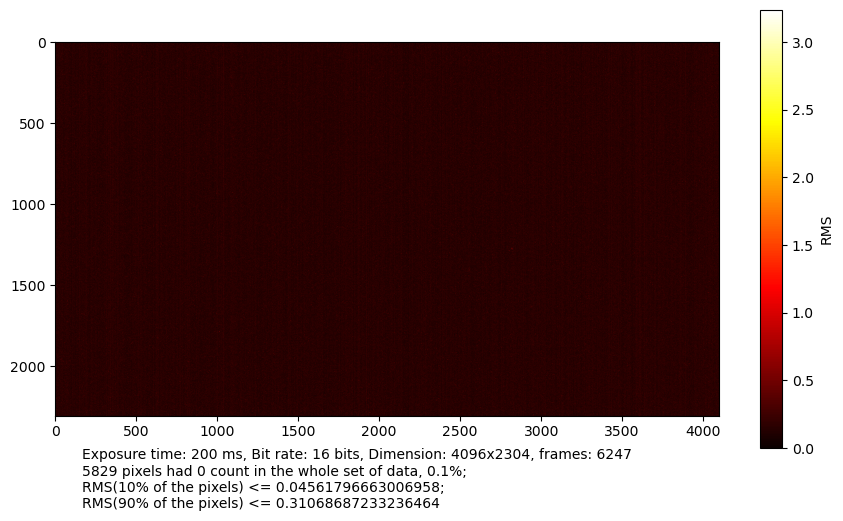

Plotting time: 2.1 seconds
bins width: 0.03238109474589351
20.7% of pixel RMS errors fall between 1 and 1.0323810947458936 counts in all 6247 frames


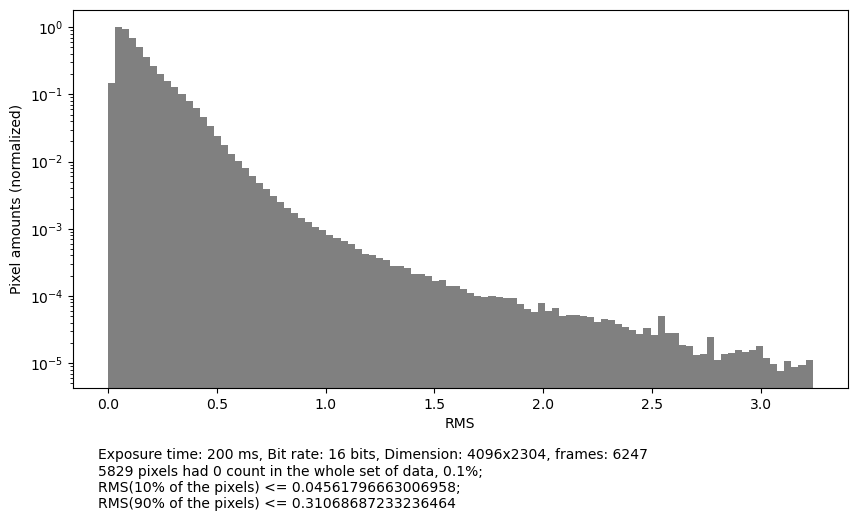

Plotting time: 1.7 seconds


In [4]:
tiff_main_folder = 'C:\\3.12 qCMOS'
# tiff_path = tiff_main_folder + '\\full_1s_6000_shot'
tiff_path = tiff_main_folder + '\\full_200ms_6247shots'
# tiff_path = tiff_main_folder + '\\1024x1024'

RMS_array = get_RMS_array_dense(tiff_path, debugging=True, pickle_usage=True)

# print(f'issparse(RMS_array)? {issparse(RMS_array)}')
plot_RMS(RMS_array, tiff_path, plot_type='heat', save=True)
plot_RMS(RMS_array, tiff_path, plot_type='bar', save=True)

In [5]:
# Check if the RMS_array is a sparse matrix
# print(type(RMS_array))

# print max and the smallest non-zero element of csr sparse matrix RMS_array with scipy
print('Max element:', RMS_array.max())
print('Min element:', RMS_array.min())
print('Min non-zero element:', RMS_array[RMS_array > 0].min())

Max element: 3.2381094745893515
Min element: 0.0
Min non-zero element: 0.012652147520547776
